### Read the data

In [1]:
import xarray as xr
import numpy as np

In [2]:
def delete_scattering_coefficients(scat_coef_1):

    # define a matrix with nans where frequency_0 / 2 < frequency_1
    masking_matrix = np.ones(scat_coef_1.shape)
    for i,f_0 in enumerate(scat_coef_1.frequency_0):
        for j,f_1 in enumerate(scat_coef_1.frequency_1):
            if f_0 < f_1:
                masking_matrix[:,i,j] = np.nan

    # apply the masking matrix to the scattering coefficients
    scat_coef_1 = scat_coef_1 * masking_matrix

    # just to check the result
    plt.pcolormesh(scat_coef_1.frequency_0, scat_coef_1.frequency_1, scat_coef_1[0].T)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    # reshape the scattering coefficients to a 2D array
    features = scat_coef_1.data.reshape(scat_coef_1.shape[0], -1)

    # exclude the features with nan values
    mask = np.isnan(features).any(axis=0)
    features = features[:,~mask]

    return features

def load_data(path2file, remove=False):
    
    with xr.open_dataset(path2file) as dset:
        scat_coef_1 = dset['scat_coef_1'].mean(dim='comp')
        scat_coef_1 /= scat_coef_1.max(dim=('frequency_0','frequency_1'))
        species_labels = dset['species'].to_numpy()
        station_labels = dset['station'].to_numpy()
        distance_labels = dset['distance'].to_numpy()
        signal_energy = dset['signal_energy'].mean(dim='comp').to_numpy()

    if remove:
        features = delete_scattering_coefficients(scat_coef_1)
    else:
        features = scat_coef_1.data.reshape(scat_coef_1.shape[0], -1)

    return features, species_labels, station_labels, distance_labels, signal_energy, scat_coef_1.frequency_0, scat_coef_1.frequency_1

In [3]:
REMOVE = False
PATH2FILE = '../data/scattering_coefficients_32_32.nc'
features, species_labels, station_labels, distance_labels, signal_energy, frequency_0, frequency_1 = load_data(PATH2FILE, remove=REMOVE)

### The UMAP atlas

In [4]:
import pickle
import umap

/home/steinre/anaconda3/envs/decoding_footsteps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
N_NEIGHBOR = 30
MIN_DIST = 0.1
COMPUTE = False

In [6]:
def return_umap_atlas(features, n_neighbors, min_dist, compute):
    if compute:
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist).fit(features)
        with open(f'../data/umap_atlas_{n_neighbors}_{min_dist}.pkl', 'wb') as f:
            pickle.dump(umap_model, f)
    else:
        with open(f'../data/umap_atlas_{n_neighbors}_{min_dist}.pkl', 'rb') as f:
            umap_model = pickle.load(f)

    return umap_model

In [7]:
# load/compute atlas
umap_model = return_umap_atlas(features, N_NEIGHBOR, MIN_DIST, COMPUTE)

# compute the 2D atlas
atlas = umap_model.transform(features)

### Showing the atlas

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [9]:
def compute_percentage_label(labels, unique_labels):
    percentage = []
    for label in unique_labels:
        where = label == labels
        percentage.append(np.sum(where) / len(where))
    return np.array(percentage)

def compute_marker_size(percentage, magnifier=.01):
    percentage_species_inversed = 1 / percentage
    size_list = 1 + percentage_species_inversed*magnifier
    return size_list

def compute_alpha(percentages, min_alpha=0.1, max_alpha=0.8, min_percentage=0.01, max_percentage=0.1):
    # Initialize the alpha array
    alphas = np.zeros_like(percentages, dtype=float)
    
    # Apply conditions
    alphas[percentages < min_percentage] = max_alpha  # For percentages below 1%
    alphas[percentages > max_percentage] = min_alpha  # For percentages above 10%
    
    # Linear interpolation for percentages between 1% and 10%
    mask = (percentages >= min_percentage) & (percentages <= max_percentage)
    alphas[mask] = max_alpha - (max_alpha-0.05) * (percentages[mask] - min_percentage) / (max_percentage - min_percentage)
    
    return alphas


In [10]:
# DEFINE COLORS, MARKERS AND ALPHA VALUES FOR THE SPECIES PLOT
color_values_species = ['C7', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8','k']

percentage_species = compute_percentage_label(species_labels, np.unique(species_labels))
alpha_values_species = compute_alpha(percentage_species)
marker_values_species = compute_marker_size(percentage_species, magnifier=0.01)

In [11]:
# DEFINE COLORS, MARKERS AND ALPHA VALUES FOR THE STATION PLOT
color_values_station = ['saddlebrown', 'chocolate', 'sandybrown', 'dimgrey', 'grey', 'lightgrey', 'red', 'magenta', 'blue']
station_list_ordered = ['WTA00','WTB00','WTC00','ETA00','ETB00','NTA02','NNL62','NWP05','STA02']

percentage_station = compute_percentage_label(station_labels, station_list_ordered)
alpha_values_station = compute_alpha(percentage_station, min_percentage=0.01, max_percentage=0.3, min_alpha=0.05, max_alpha=0.6)
marker_values_station = compute_marker_size(percentage_station, magnifier=0.01)

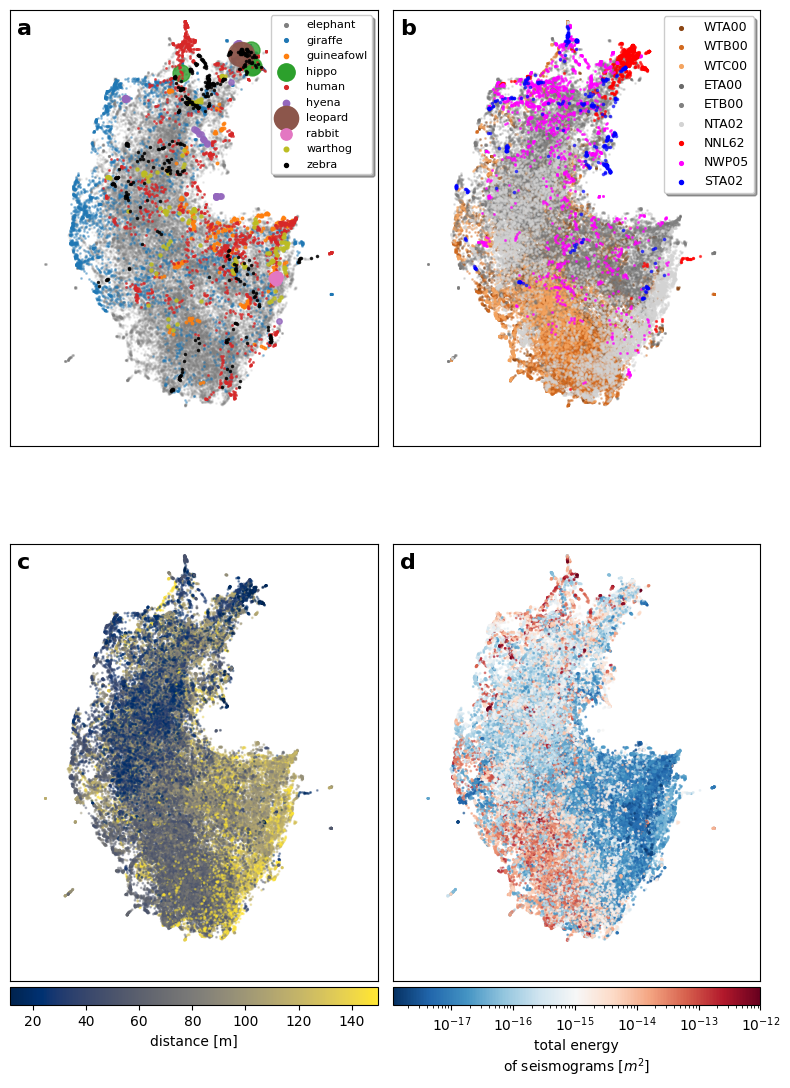

In [12]:
# INIT FIGURE
fig = plt.figure(figsize=(8, 12))#, layout="constrained")

# Adjust GridSpec to create a 2x2 grid
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], aspect='equal', adjustable='box')  # Top-left
ax2 = fig.add_subplot(gs[0, 1], aspect='equal', adjustable='box', sharex=ax1, sharey=ax1)  # Top-right
ax3 = fig.add_subplot(gs[1, 0], aspect='equal', adjustable='box', sharex=ax1, sharey=ax1)  # Bottom-left
ax4 = fig.add_subplot(gs[1, 1], aspect='equal', adjustable='box', sharex=ax1, sharey=ax1)  # Bottom-right

# Subplot with species labels
for i, species in enumerate(np.unique(species_labels)):
    where = species == species_labels
    ax1.scatter(atlas[where, 0], atlas[where, 1], s=marker_values_species[i], alpha=alpha_values_species[i], label=species, c=color_values_species[i], rasterized=True)
lgnd = ax1.legend(fancybox=True, shadow=True, ncol=1, fontsize=8)
for i,handle in enumerate(lgnd.legend_handles):
    handle.set_sizes([6.0+marker_values_species[i]])
    handle.set_alpha(1)
ax1.set_xlim(0,16)
ax1.set_ylim(-6.5,12.5)

# Subplot with station labels
for i, station in enumerate(station_list_ordered):
    where = station == station_labels
    ax2.scatter(atlas[where,0],atlas[where,1],s=marker_values_station[i],alpha=alpha_values_station[i],label=station,c=color_values_station[i], rasterized=True)
lgnd = ax2.legend(loc='upper right', fancybox=True, shadow=True, ncol=1, fontsize=9)
for i,handle in enumerate(lgnd.legend_handles):
    handle.set_sizes([6.0+marker_values_station[i]])
    handle.set_alpha(1)

# Subplot with animal-sensor distance
img = ax3.scatter(atlas[:, 0], atlas[:, 1], s=1, alpha=0.4, c=distance_labels, cmap='cividis', rasterized=True)
ax3.set(xticks=[], yticks=[])
cbar = fig.colorbar(img, ax=ax3, orientation='horizontal', pad=0.01)
cbar.set_label('distance [m]')
cbar.solids.set(alpha=1)

# Subplot with signal energy
img = ax4.scatter(atlas[:, 0], atlas[:, 1], s=1, alpha=0.6, c=signal_energy, cmap='RdBu_r',
                  norm=colors.LogNorm(vmin=signal_energy.min(), vmax=10**-12), rasterized=True)
cbar = fig.colorbar(img, ax=ax4, orientation='horizontal', pad=0.01)
cbar.set_label('total energy\nof seismograms [$m^2$]')
cbar.solids.set(alpha=1)

# Labeling subplots
ax1.text(0.02, 0.98, 'a', transform=ax1.transAxes, fontsize=16, verticalalignment='top', weight='bold')
ax2.text(0.02, 0.98, 'b', transform=ax2.transAxes, fontsize=16, verticalalignment='top', weight='bold')
ax3.text(0.02, 0.98, 'c', transform=ax3.transAxes, fontsize=16, verticalalignment='top', weight='bold')
ax4.text(0.02, 0.98, 'd', transform=ax4.transAxes, fontsize=16, verticalalignment='top', weight='bold')

#fig.subplots_adjust(wspace=0.001, hspace=0.0001)
fig.tight_layout()
#fig.savefig('../paper_figures/main/umap_atlas.pdf', bbox_inches='tight')
plt.show()

### Reconstruction figure

In [13]:
def reconstruct_scattering_coefficients(features, scat_coef_1_shape, frequency_0, frequency_1):
    # Initialize a matrix of NaNs with the original shape of scat_coef_1
    reconstructed_scat_coef_1 = np.full(scat_coef_1_shape, np.nan)

    # Recreate the mask that was used in the original function
    masking_matrix = np.ones(scat_coef_1_shape)
    for i, f_0 in enumerate(frequency_0):
        for j, f_1 in enumerate(frequency_1):
            if f_0 < f_1:
                masking_matrix[:, i, j] = np.nan

    # Flatten the masking matrix to align it with the reshaped scat_coef_1
    mask_flat = np.isnan(masking_matrix.flatten())

    # Create a flattened version of the NaN-filled matrix
    flat_reconstructed = reconstructed_scat_coef_1.flatten()

    # Insert the features back into the flattened matrix at positions where the mask is not NaN
    flat_reconstructed[~mask_flat] = features.flatten()

    # Reshape the flat array back to the original shape
    reconstructed_scat_coef_1 = flat_reconstructed.reshape(scat_coef_1_shape)

    return reconstructed_scat_coef_1

def compute_reconstruction(corners, n_rows, n_cols, umap_model, scat_coef_size, remove, frequency_0, frequency_1):

    test_pts = np.array([
        (corners[0]*(1-x) + corners[1]*x)*(1-y) +
        (corners[2]*(1-x) + corners[3]*x)*y
        for y in np.linspace(0, 1, n_cols)
        for x in np.linspace(0, 1, n_rows)
    ])

    inv_transformed_points = umap_model.inverse_transform(test_pts)

    # reshape the vectorized scattering coefficients to the original shape
    if remove:
        scat_coef_1_shape = (len(test_pts), scat_coef_size[0], scat_coef_size[1])
        reconstructed_scat_coef = reconstruct_scattering_coefficients(inv_transformed_points, scat_coef_1_shape, frequency_0, frequency_1)
        
    else:
        reconstructed_scat_coef = inv_transformed_points.reshape(len(test_pts),scat_coef_size[0], scat_coef_size[1])

    return reconstructed_scat_coef, test_pts

In [14]:
corners = np.array([
    [5, -4], # bottom left
    [2, 6], # top left
    [10, -4], # bottom right
    [9, 10.5], # top right
])

n_rows = 6
n_cols = 5
scat_coef_size = (len(frequency_0), len(frequency_1))

reconstructed_scat_coef, test_pts = compute_reconstruction(corners, n_rows, n_cols, umap_model, scat_coef_size, REMOVE, frequency_0=frequency_0, frequency_1=frequency_1)

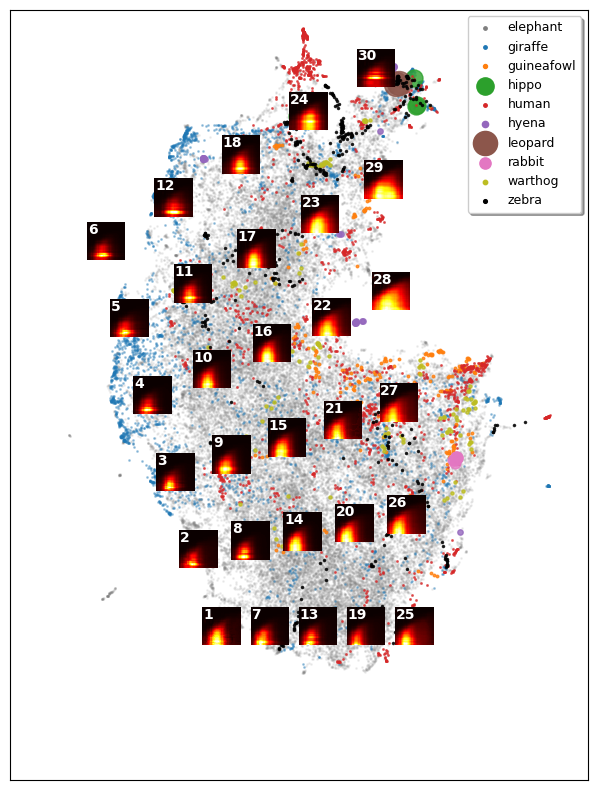

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.scatter(atlas[:,0],atlas[:,1],s=1,alpha=0.1,c='grey')
for i,species in enumerate(np.unique(species_labels)):
    where = species == species_labels
    ax.scatter(atlas[where,0],atlas[where,1],s=marker_values_species[i],alpha=alpha_values_species[i],label=species,c=color_values_species[i])
ax.set_xlim(0,15)
ax.set_ylim(-7.5,12.5)
ax.set_aspect('equal')
ax.set(xticks=[], yticks=[])

lgnd = ax.legend(loc='upper right', shadow=True, ncol=1, fontsize=9)
for i,handle in enumerate(lgnd.legend_handles):
    handle.set_sizes([5+marker_values_species[i]])
    handle.set_alpha(1)

for i,coordinates in enumerate(test_pts):

    axins = inset_axes(ax, width="100%", height="100%",
                        bbox_to_anchor=(coordinates[0], coordinates[1], 1, 1),
                        bbox_transform=ax.transData, loc=2, borderpad=0)

    axins.pcolor(frequency_0,frequency_1,reconstructed_scat_coef[i].T,shading='auto',cmap='hot')
    axins.set_xscale('log')
    axins.set_yscale('log')
    axins.set(xticks=[], yticks=[])
    axins.axis('off')
    axins.text(0.02, 0.98, f'{i+1}', transform=axins.transAxes, fontsize=10, verticalalignment='top', weight='bold', color='white')

### Not relevant

Text(0.02, 0.98, 'd')

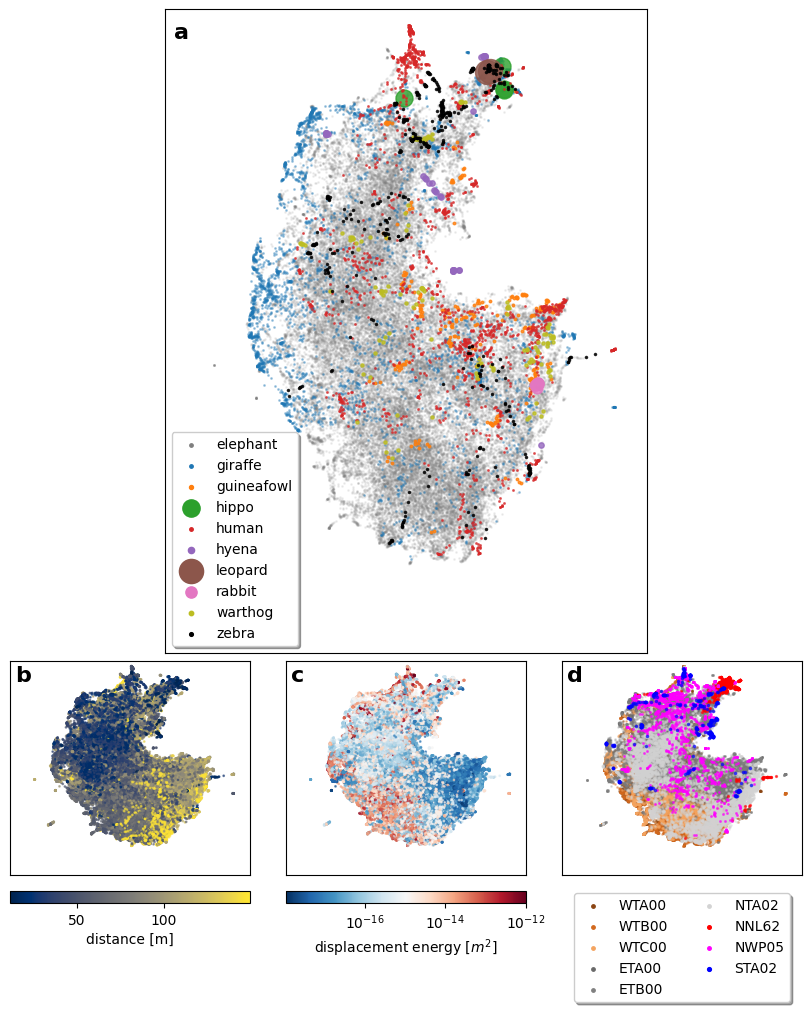

In [16]:

# INIT FIGURE
#fig, scatter_ax = plt.subplots(figsize=(15,15))
fig = plt.figure(figsize=(8,10),layout="constrained")

gs = GridSpec(4, 3, figure=fig)
scatter_ax = fig.add_subplot(gs[:3, :])
ax1 = fig.add_subplot(gs[3, 0],sharex=scatter_ax,sharey=scatter_ax)
ax2 = fig.add_subplot(gs[3, 1],sharex=scatter_ax,sharey=scatter_ax)
ax3 = fig.add_subplot(gs[3, 2],sharex=scatter_ax,sharey=scatter_ax)


s=1

for i,species in enumerate(np.unique(species_labels)):
    where = species == species_labels
    scatter_ax.scatter(atlas[where,0],atlas[where,1],s=marker_values_species[i],alpha=alpha_values_species[i],label=species,c=color_values_species[i])

scatter_ax.set_xlim(0,15)
scatter_ax.set_ylim(-7.5,12.5)
scatter_ax.set_aspect('equal')
scatter_ax.set(xticks=[], yticks=[])

# for i,coordinates in enumerate(test_pts):

#     axins = inset_axes(scatter_ax, width="100%", height="100%",
#                         bbox_to_anchor=(coordinates[0], coordinates[1], .8, .8),
#                         bbox_transform=scatter_ax.transData, loc=2, borderpad=0)

#     axins.pcolor(frequency_0,frequency_1,inv_transformed_feature_maps[i],shading='auto',cmap='hot')
#     axins.set_xscale('log')
#     axins.set_yscale('log')
#     axins.set(xticks=[], yticks=[])
#     axins.axis('off')

# add legend to the scatter plot at the top
lgnd = scatter_ax.legend(loc='lower left', shadow=True, ncol=1)
for i,handle in enumerate(lgnd.legend_handles):
    handle.set_sizes([5+marker_values_species[i]])
    handle.set_alpha(1)

# SUBPLOT WITH ANIMAL-SENSOR DISTANCE
img=ax1.scatter(atlas[:,0],atlas[:,1],s=1,alpha=0.6,c=distance_labels,cmap='cividis')
cbar = fig.colorbar(img, ax=ax1, orientation='horizontal',pad=-0.5)
cbar.set_label('distance [m]')
cbar.solids.set(alpha=1)
#ax1.set_aspect('equal')

# SUBPLOT WITH SIGNAL ENERGY
img=ax2.scatter(atlas[:,0],atlas[:,1],s=1,alpha=0.6,c=signal_energy, cmap='RdBu_r', norm=colors.LogNorm(vmin=signal_energy.min(), vmax=10**-12))
cbar = fig.colorbar(img, ax=ax2, orientation='horizontal',pad=-0.5)
cbar.set_label('displacement energy [$m^2$]')
cbar.solids.set(alpha=1)

# SUBPLOT WITH STATION LABELS
for i,station in enumerate(station_list_ordered):
    where = station == station_labels
    ax3.scatter(atlas[where,0],atlas[where,1],s=marker_values_station[i],alpha=alpha_values_station[i],label=station,c=color_values_station[i])
lgnd = ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

for i,handle in enumerate(lgnd.legend_handles):
    handle.set_sizes([5+marker_values_station[i]])
    handle.set_alpha(1)

scatter_ax.text(0.02, 0.98, 'a', transform=scatter_ax.transAxes, fontsize=16, verticalalignment='top',weight='bold')
ax1.text(0.02, 0.98, 'b', transform=ax1.transAxes, fontsize=16, verticalalignment='top',weight='bold')
ax2.text(0.02, 0.98, 'c', transform=ax2.transAxes, fontsize=16, verticalalignment='top',weight='bold')
ax3.text(0.02, 0.98, 'd', transform=ax3.transAxes, fontsize=16, verticalalignment='top',weight='bold')